## Описание

Компания «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. \

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользовате лей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

<div style="border:solid blue 2px; padding: 20px">
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

### Описание данных

Таблица **`users`** (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица **`calls`** (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица **`messages`** (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица **`internet`** (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица **`tariffs`** (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Введение

- Для начала предстоит познакомиться с данными: какие таблицы нам даны? какие типы данных в этих таблицах. 
- После этого необходимо будет выполнить предобработку данных: привести данные к нужным типам, избавиться от ошибок (если они есть), проверить дубликаты, заполнить пропуски
- После этого необходимо будет посчитать помесяные траты минут, сообщений и интернета для каждого пользователя. 
- Далее можно будет приступить к анализу общих данных: посмотреть на длительность звонков в среднем, кол-во смс, используемый интернет-трафик
- Далее разобьем данные на 2 датафрейма по тариффам и выполним небольшой сравнительный анализ ключевых показателей по тарифам. 
- Затем очистим данные от выбросов, выдвенем гипотезы и проведем статистические тесты, чтобы постараться ответить на запрос бизнеса

---

## Ознакомление с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
    users = pd.read_csv('users.csv')
except:
    calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
    internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
    messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
    tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')                        

In [3]:
pd.options.display.max_columns=50

In [4]:
display(calls.head())
display(calls.info())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

In [5]:
display(internet.head())
display(internet.info())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

In [6]:
display(messages.head())
display(messages.info())

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

In [7]:
display(tariffs.head())
display(tariffs.info())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

In [8]:
display(users.head())
display(users.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

In [9]:
users[users['churn_date'].notnull()].groupby('tariff')['user_id'].count()

tariff
smart    23
ultra    15
Name: user_id, dtype: int64

<div style="border:solid blue 2px; padding: 20px">
Думал сразу посмотреть с какого тарифа люди уходят чаще, но по этим данным сделать какой-либо вывод невозможно. Их и очень мало и цифры отличаются несильно. 

Данные выглядят на удивление неплохо. Практически нет пропусков, имена колонок в порядке. Но некоторую предобработку я все-таки выполню

---

## Предобработка данных

Займемся предобработкой данных: проверим на пропуски, дубликаты, аномалии. Также разберемся с типами данных

Для начала поменяем float64 и int64 на более экономичные для памяти типы данных во всех датафреймах. 

In [10]:
data_list = [calls, internet, messages, tariffs, users]

#Цикл пробегается по всем типам данных и меняет  float64 и int64 на  float32 и int32.
for i in data_list:
    for col in i:
        if i[col].dtype == 'float64':
            i[col] = i[col].astype('float32')
        elif i[col].dtype == 'int64':
            i[col] = i[col].astype('int32')

Также я видел в таблицах calls, internet, messages и users столбцы с датой. Предлагаю поменять их на необходимый формат

In [11]:
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date']= pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date']= pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['reg_date']= pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Пропуски встречаются в колонке churn_date (дата прекращения пользования тарифом). В данном случае, клиенты просто продолжали пользоваться тарифом на момент выгрузки данных. Заменять пропуски считаю бессмысленным. \
Все, на мой взгяд, данные приведены в нужный формат. 

Теперь разберемся с каждой таблицей отдельно. Проверим данные на ошибки и попробуем составить первое впечатление о данных. 

---

## Звоники

<AxesSubplot:>

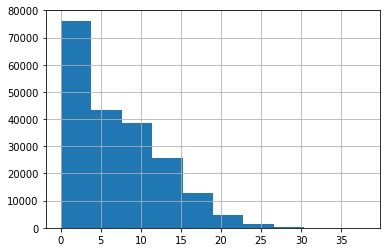

In [12]:
calls['duration'].hist()

На гистограмме можно заметить большое кол-во звонков с длительностью 0. Вероятнее всего, это пропущенные вызовы либо абонент не дозвонился до адресата. 

Посчитаем количесвто звонков для каждого пользователья по месяцам

In [13]:
# Добавим колонку с месяцем
calls['month'] = calls['call_date'].dt.month

Поскольку для обоих тарифов каждый звонок окргуляется отдельно до минут, сразу произведем округление длительности звонков

In [14]:
calls['duration'] = np.ceil(calls['duration']).astype('int32')

Теперь создадим сводник по звонкам за месяц для каждого пользователя. 

,user_id,month,calls_count,calls_duration_total
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


,calls_count,calls_duration_total
count,3174.000000,3174.000000
mean,63.833333,456.931632
std,32.678036,238.031270
min,1.000000,0.000000
25%,41.000000,290.000000
50%,63.000000,447.000000
75%,83.000000,592.000000
max,244.000000,1673.000000


<AxesSubplot:>

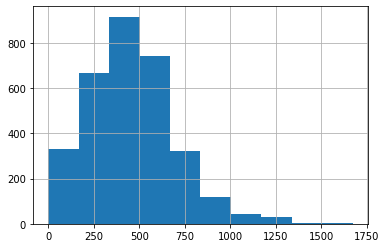

In [15]:
calls_by_month =(
calls
    .groupby(['user_id', 'month'])['duration']
    .agg(['count', 'sum'])
    .reset_index()
    .rename(columns={'count': 'calls_count', 'sum': 'calls_duration_total'})
)
display(calls_by_month.head())
display(calls_by_month[['calls_count', 'calls_duration_total']].describe())
display(calls_by_month['calls_duration_total'].hist())

Большинство клиентов разговаривают по 0-600 минут в месяц. Медиана и среднее на отметке около 450 минут. 

---

##  Сообщения

Теперь посчитаем количество смс-сообщений для каждого пользователя по месяцам.

In [16]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [17]:
messages['month'] = messages['message_date'].dt.month

count    2717.000000
mean       45.283769
std        35.051363
min         1.000000
25%        19.000000
50%        38.000000
75%        63.000000
max       224.000000
Name: messages_count, dtype: float64

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


<AxesSubplot:>

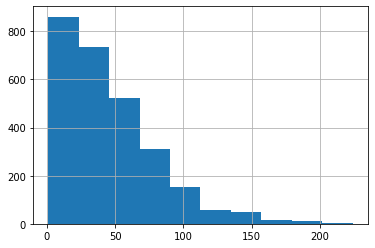

In [18]:
messages_by_month = (
messages
    .groupby(['user_id', 'month'])
    .agg(count = ('id','count'),)
    .reset_index()
    .rename(columns={'count': 'messages_count'})
)
display(messages_by_month['messages_count'].describe())
display(messages_by_month.head())
display(messages_by_month['messages_count'].hist())

В среднем люди отправляют примерно по 40-45 смс в месяц.

---

## Интернет

In [19]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.949997,2018-11-25,1000
1,1,1000_1,1052.810059,2018-09-07,1000
2,2,1000_2,1197.260010,2018-06-25,1000
3,3,1000_3,550.270020,2018-08-22,1000
4,4,1000_4,302.559998,2018-09-24,1000


In [20]:
internet['month'] = internet['session_date'].dt.month

Поскольку оператор округляет мб до гб, предлагаю после построения сводной таблицы поделить использованные мб на 1024 и округлить в бОльшую сторону

count    3203.000000
mean       17.358414
std         7.343379
min         0.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        49.000000
Name: gb_used, dtype: float64

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


<AxesSubplot:>

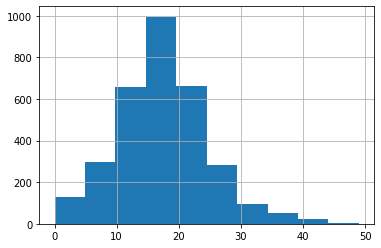

In [21]:
internet_by_month = (
internet
    .groupby(['user_id', 'month'])['mb_used']
    .agg('sum')
    .reset_index()
)
internet_by_month['gb_used'] = np.ceil(internet_by_month['mb_used'] / 1024).astype('int32')
internet_by_month = internet_by_month.drop('mb_used', axis=1) # удалим колонку с использованными мб за ненадобностью. 
display(internet_by_month['gb_used'].describe())
display(internet_by_month.head())
display(internet_by_month['gb_used'].hist())

В среднем клиенты израсходуют около 17 гб в месяц. 

___

## Формирование общего датафрейма

Объеденим полученные таблицы со звонками, смс и интрнетом за месяц в один датафрейм

In [22]:
# Поскольку мы перевели мб в гб в нашем своднике, необходимо перевести мб в гб и в таблице для условий по тарифам.
tariffs.insert(1, 'gb_per_month_included', (tariffs['mb_per_month_included']/1024).astype('int32'))

In [23]:
# Соеденим таблицы со звонками, смс и интернетом
data_by_month = pd.merge(pd.merge(calls_by_month, messages_by_month, how='outer', on=['user_id', 'month']), internet_by_month, how='outer', on=['user_id', 'month'])

# Добавим таблицу с информацией о пользователях
df = pd.merge(data_by_month, users[['user_id', 'city', 'tariff']], on='user_id', how='left')

# И наконец добавим в общий датафрейм условия по тарифам
df = df.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')

Теперь у нас есть общий датафрейм со всеми необходимыми данными для каждого пользователя. 

In [24]:
df.sample(10)

,user_id,month,calls_count,calls_duration_total,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1658,1266,9,50.0,339.0,45.0,13.0,Калуга,smart,50,15,15360,500,550,200,3,3,smart
2328,1373,12,1.0,15.0,55.0,24.0,Улан-Удэ,smart,50,15,15360,500,550,200,3,3,smart
1410,1224,10,84.0,600.0,NaN,25.0,Магнитогорск,smart,50,15,15360,500,550,200,3,3,smart
2419,1384,4,12.0,85.0,NaN,1.0,Нижний Новгород,smart,50,15,15360,500,550,200,3,3,smart
1274,1202,9,11.0,75.0,20.0,9.0,Владивосток,smart,50,15,15360,500,550,200,3,3,smart
3022,1475,5,33.0,291.0,30.0,14.0,Новокузнецк,smart,50,15,15360,500,550,200,3,3,smart
264,1043,10,67.0,512.0,10.0,23.0,Ставрополь,smart,50,15,15360,500,550,200,3,3,smart
2915,1458,7,106.0,816.0,1.0,10.0,Барнаул,ultra,1000,30,30720,3000,1950,150,1,1,ultra
1903,1303,8,69.0,540.0,27.0,21.0,Смоленск,ultra,1000,30,30720,3000,1950,150,1,1,ultra
401,1064,3,33.0,166.0,26.0,7.0,Якутск,smart,50,15,15360,500,550,200,3,3,smart


Очевидно, что после merge в датафрейме будут пустые значения.

In [25]:
df.isna().mean()

user_id                  0.000000
month                    0.000000
calls_count              0.012446
calls_duration_total     0.012446
messages_count           0.154636
gb_used                  0.003423
city                     0.000000
tariff                   0.000000
messages_included        0.000000
gb_per_month_included    0.000000
mb_per_month_included    0.000000
minutes_included         0.000000
rub_monthly_fee          0.000000
rub_per_gb               0.000000
rub_per_message          0.000000
rub_per_minute           0.000000
tariff_name              0.000000
dtype: float64

Пропуски обнаружены в колонках: кол-во звонков, длительность звонков, кол-во сообщений и траффик в гб. Логичнее всего предположить, что в указанных месяцах клиент не отправлял смс, не делал звонков или не выходил в интернет. Заменяем но 0. 

In [26]:
# Создадим функцию, которая меняет на ноль пропуски в колонках. 
def fill_nan(data):
    for col in data.columns:
        if data[col].isna().mean() > 0:
            data[col] = data[col].fillna(0)
fill_nan(df)
display(df.isna().mean())
display(df.duplicated().sum())

user_id                  0.0
month                    0.0
calls_count              0.0
calls_duration_total     0.0
messages_count           0.0
gb_used                  0.0
city                     0.0
tariff                   0.0
messages_included        0.0
gb_per_month_included    0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64

0

Отлично. От пропусков избавились, дубликатов нет. 
Для полного анализа нам необходимо также посчитать помесячную выручку с каждого пользователя. 

In [27]:
# Функция для подсчета выручки
def profit(data):
    prof = data['rub_monthly_fee']
    if data['messages_count'] - data['messages_included'] > 0:
        prof += (data['messages_count'] - data['messages_included']) * data['rub_per_message']
    if data['calls_duration_total'] - data['minutes_included'] > 0:
        prof += (data['calls_duration_total'] - data['minutes_included']) * data['rub_per_minute']
    if data['gb_used'] - data['gb_per_month_included'] > 0:
        prof += (data['gb_used'] - data['gb_per_month_included']) * data['rub_per_gb']
    return int(prof)

# Добавим колонкис выручкой, суммой переплаты
df['profit'] = df.apply(profit, axis=1)
df['overpaid'] = df['profit'] - df['rub_monthly_fee']

In [28]:
# Функция для добавления колонки с наличием переплаты (1- есть переплата, 0 - нет переплаты)

def overpaid(data):
    if data['overpaid'] == 0:
        return 0
    else:
        return 1

df['overpayment'] = df.apply(overpaid, axis=1)

In [29]:
# Проверим корректность выгрузки
df.sample(10)

,user_id,month,calls_count,calls_duration_total,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,profit,overpaid,overpayment
63,1009,3,13.0,109.0,2.0,8.0,Пермь,smart,50,15,15360,500,550,200,3,3,smart,550,0,0
1075,1172,12,56.0,414.0,4.0,24.0,Санкт-Петербург,smart,50,15,15360,500,550,200,3,3,smart,2350,1800,1
2035,1325,8,79.0,575.0,19.0,25.0,Новосибирск,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
1080,1173,10,119.0,841.0,14.0,21.0,Красноярск,smart,50,15,15360,500,550,200,3,3,smart,2773,2223,1
973,1155,11,69.0,554.0,47.0,16.0,Ставрополь,smart,50,15,15360,500,550,200,3,3,smart,912,362,1
2803,1439,6,2.0,10.0,0.0,1.0,Орёл,smart,50,15,15360,500,550,200,3,3,smart,550,0,0
2403,1381,10,100.0,643.0,43.0,23.0,Москва,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
556,1089,2,2.0,5.0,27.0,3.0,Иркутск,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
3078,1482,2,2.0,24.0,2.0,1.0,Санкт-Петербург,smart,50,15,15360,500,550,200,3,3,smart,550,0,0
621,1099,8,97.0,724.0,47.0,15.0,Тольятти,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0


________

## Анализ данных

Опишем поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы

Для сравнительного анализа пользователей двух разных тарифов предлагаю разбить наш датафрейм на 2

In [30]:
df_smart = df[df['tariff'] == 'smart'].reset_index(drop=True)

In [31]:
df_ultra = df[df['tariff'] == 'ultra'].reset_index(drop=True)

In [32]:
df_smart.head()

,user_id,month,calls_count,calls_duration_total,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,profit,overpaid,overpayment
0,1001,11,59.0,430.0,0.0,18.0,Москва,smart,50,15,15360,500,550,200,3,3,smart,1150,600,1
1,1001,12,63.0,414.0,0.0,14.0,Москва,smart,50,15,15360,500,550,200,3,3,smart,550,0,0
2,1002,6,15.0,117.0,4.0,11.0,Стерлитамак,smart,50,15,15360,500,550,200,3,3,smart,550,0,0
3,1002,7,26.0,214.0,11.0,18.0,Стерлитамак,smart,50,15,15360,500,550,200,3,3,smart,1150,600,1
4,1002,8,42.0,289.0,13.0,20.0,Стерлитамак,smart,50,15,15360,500,550,200,3,3,smart,1550,1000,1


In [33]:
df_ultra.head()

,user_id,month,calls_count,calls_duration_total,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,profit,overpaid,overpayment
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0


### Анализ звонков

tariff,smart,ultra
mean,417.934948,526.623350
median,422.000000,518.000000
var,36219.315784,100873.633397
std,190.313730,317.606098


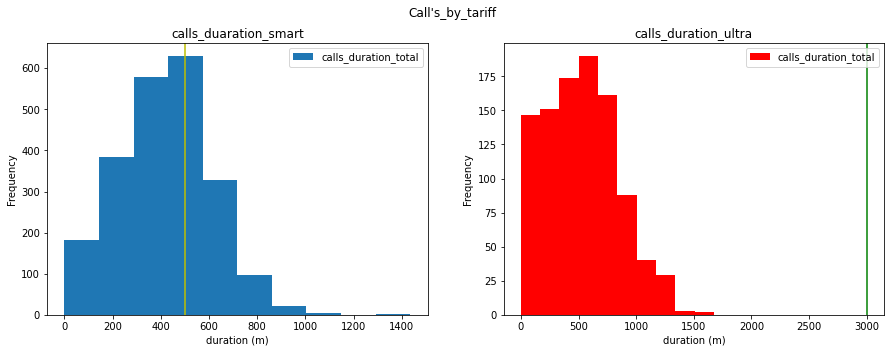

In [34]:
# Построение гистрограмм
fig, axs = plt.subplots(1,2)
fig.suptitle("Call's_by_tariff")
fig.set_figheight(5)
fig.set_figwidth(15)
df_smart['calls_duration_total'].plot.hist(ax=axs[0])
axs[0].axvline(df_smart['minutes_included'].mean(), color='y')
axs[0].set_title('calls_duaration_smart') 
axs[0].set_xlabel('duration (m)')
axs[0].legend(loc='upper right')
df_ultra['calls_duration_total'].plot.hist(ax=axs[1], color = "r")
axs[1].set_title('calls_duration_ultra') 
axs[1].set_xlabel('duration (m)')
axs[1].legend(loc='upper right')
axs[1].axvline(df_ultra['minutes_included'].mean(), color='g')

# Сводник для сравнения
df.groupby('tariff')['calls_duration_total'].agg(['mean', 'median', 'var', 'std']).T

<div style="border:solid blue 2px; padding: 20px">
В среднем пользователи смарта выговариваю по 417 минут из 500 включенных в тариф. Пользователи ультры выговваривают лишь по 526 минут из 3000 включенных в тариф. Можно заключить, что пользователи смарта более целостно используют тариф, в то время как пользователи ультры в среднем выговаривают лишь по 17% от включенных в тариф минут. \
Также я добавил на график линию, которой обозначены включенные в тариф минуты. Из них видно, что пользователи смарта намного чаще выходят за лимит по минутам звонков, а пользователей ультры, который выговариваю более 3000 минут и вовсе нет. \
График по тарифу смарт выглядит более нормальным, чем график тарифа ультра, который имеет положительную ассиметрию. Это также видно при сравнении среднего и медианы. У тарифа смарт среднее меньше отличается от медианы, нежели чем в тарифе ультра

### Анализ сообщений

tariff,smart,ultra
mean,33.384029,49.363452
median,28.000000,38.000000
var,796.812958,2285.266143
std,28.227876,47.804457


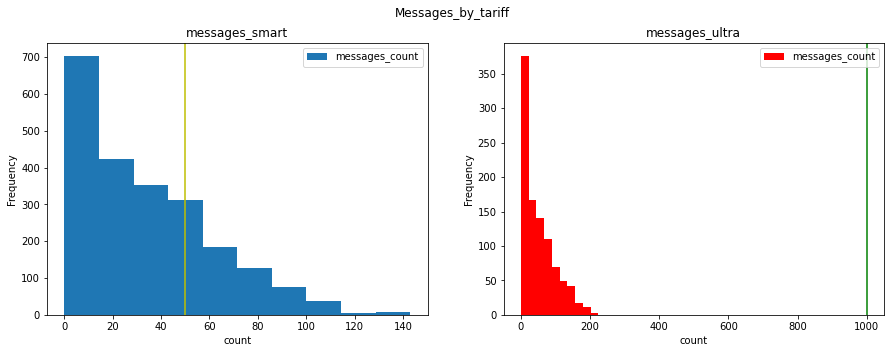

In [35]:
# Построение гистрограмм
fig, axs = plt.subplots(1,2)
fig.suptitle("Messages_by_tariff")
fig.set_figheight(5)
fig.set_figwidth(15)
df_smart['messages_count'].plot.hist(ax=axs[0])
axs[0].axvline(df_smart['messages_included'].mean(), color='y')
axs[0].set_title('messages_smart') 
axs[0].set_xlabel('count')
axs[0].legend(loc='upper right')
df_ultra['messages_count'].plot.hist(ax=axs[1], color = "r")
axs[1].set_title('messages_ultra') 
axs[1].set_xlabel('count')
axs[1].legend(loc='upper right')
axs[1].axvline(df_ultra['messages_included'].mean(), color='g')

# Сводник для сравнения
df.groupby('tariff')['messages_count'].agg(['mean', 'median', 'var', 'std']).T

<div style="border:solid blue 2px; padding: 20px">
С сообщениями картина в целом похожа на звонки. Пользователи смарта чаще выходят за лимит, а пользователи ультры отправляют максимум по 200 сообщений, хотя лимит 1000. Среднее для тарифов смарт и ультра на отметказ 33 и 49 сообщений соответсвенно. Медиана - 28 и 38.

### Анализ интернета

tariff,smart,ultra
mean,16.328847,19.494416
median,17.000000,19.000000
var,33.028705,97.091686
std,5.747061,9.853511


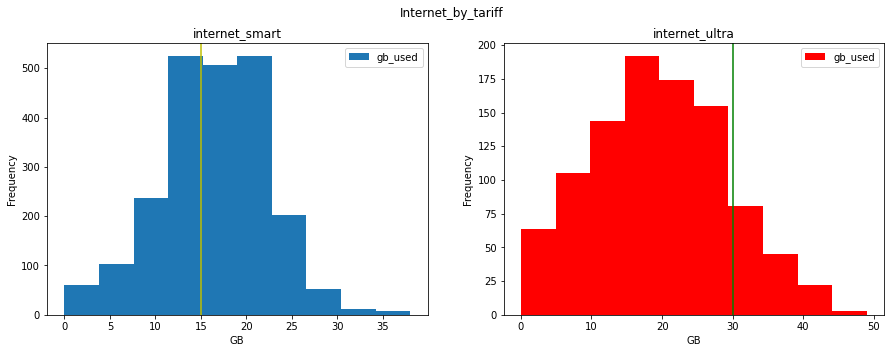

In [36]:
# Построение гистрограмм
fig, axs = plt.subplots(1,2)
fig.suptitle("Internet_by_tariff")
fig.set_figheight(5)
fig.set_figwidth(15)
df_smart['gb_used'].plot.hist(ax=axs[0])
axs[0].axvline(df_smart['gb_per_month_included'].mean(), color='y')
axs[0].set_title('internet_smart') 
axs[0].set_xlabel('GB')
axs[0].legend(loc='upper right')
df_ultra['gb_used'].plot.hist(ax=axs[1], color = "r")
axs[1].set_title('internet_ultra') 
axs[1].set_xlabel('GB')
axs[1].legend(loc='upper right')
axs[1].axvline(df_ultra['gb_per_month_included'].mean(), color='g')

# Сводник для сравнения
df.groupby('tariff')['gb_used'].agg(['mean', 'median', 'var', 'std']).T

<div style="border:solid blue 2px; padding: 20px">
С интернетом картина отличается. Пользователи обоих тарифов чаще превышают лимит. У пользователей смартра и среднее и медиана и вовсе лежат за допустимым лимитом. Пользователи ультры менее часто превышают лимит, но все же достаточно. Медина и среднее для ультры примерно равны и находятся на отметке в 19 гб. 

### Анализ выручки

tariff                      smart          ultra
profit      mean      1289.973531    2070.152284
            median    1023.000000    1950.000000
            var     669785.708006  141516.745079
            std        818.404367     376.187114
overpaid    mean       739.973531     120.152284
            median     473.000000       0.000000
            var     669785.708006  141516.745079
            std        818.404367     376.187114
overpayment mean         0.745626       0.136041
            median       1.000000       0.000000
            var          0.189753       0.117653
            std          0.435607       0.343006

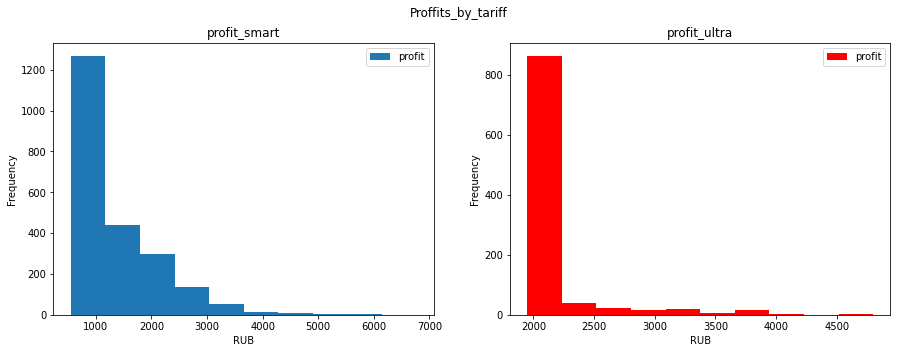

In [37]:
# Построение гистрограмм
fig, axs = plt.subplots(1,2)
fig.suptitle("Proffits_by_tariff")
fig.set_figheight(5)
fig.set_figwidth(15)
df_smart['profit'].plot.hist(ax=axs[0])
axs[0].set_title('profit_smart') 
axs[0].set_xlabel('RUB')
axs[0].legend(loc='upper right')
df_ultra['profit'].plot.hist(ax=axs[1], color = "r")
axs[1].set_title('profit_ultra') 
axs[1].set_xlabel('RUB')
axs[1].legend(loc='upper right')


# Сводник для сравнения
df.groupby('tariff')[['profit', 'overpaid', 'overpayment']].agg(['mean', 'median', 'var', 'std']).T

<div style="border:solid blue 2px; padding: 20px">
Анализируя предыдущие данные, можно было предположить, что пользователи смарта намного больше переплачивают сверх тарифа. График и сводная таблица жто подтверждают. Пользователи смарта в  **74(!)%** случаев переплачивают по тарифу, в то время как пользователи ультры лишь в 13% случаев. В среднем пользователи смарта переплачивают по 739 рублей. 

____

## Проверка гипотез

### Очистка данных

Перед проведением статистических тестов предлагаю очистить наши данные от выбросов, тк они могут существенно повлиять на результаты. 

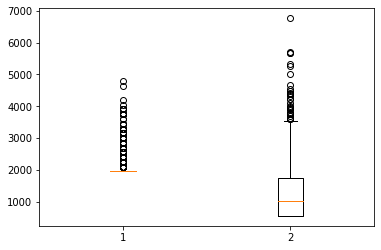

In [38]:
plt.boxplot([df_ultra['profit'], df_smart['profit']]);

In [39]:
# Создадим функцию для очистки данных
def clean_data(data, column):
    q1 = data[column].quantile(0.25)                 
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (data[column] >= (q1 - 1.5 * iqr)) & (data[column] <= (q3 + 1.5 * iqr))
    return data.loc[iqr_test]

# Применим функцию к датафреймам
df_smart = clean_data(df_smart, 'profit')
df_ultra = clean_data(df_ultra, 'profit')

Поскольку наши данные являются выборками из ГС и выборками независимыми между собой, мы будем применять T-Test Стьюдента. 

###  Проверка первой гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформируем нулевую и альтернативную гипотезы:
- H0 - Средняя выручка пользователей тарифов "Смарт" и "Ультра" не различаются. 
- H1 - Средняя выручка пользователей тарифов "Смарт" и "Ультра"  различаются.

In [40]:
# Зададим уровень значимости в 5%
alpha = 0.05

# Результат теста
results = st.ttest_ind(df_smart['profit'], df_ultra['profit'])

# Выведем на экран значение p-уровня значимости
print(f'p-значение: {results.pvalue}')

# Ответ
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.199325734910118e-155
Отвергаем нулевую гипотезу


Уровень p-значимости невероятно мал. Это значит, что вероятность получить такой результат или более далекий от предполагаемого ничтожно мала. Мы смело отвергаем нулевую гипотезу.

###  Проверка второй гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для начала необходимо разбить наши данные на 2 датафрейма: Москва и Регионы

In [41]:
df.head()

,user_id,month,calls_count,calls_duration_total,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,profit,overpaid,overpayment
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0


In [42]:
df['city'].sort_values().unique()

array(['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород',
       'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград',
       'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург',
       'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга',
       'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск',
       'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва',
       'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород',
       'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск',
       'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск',
       'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара',
       'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск',
       'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь',
       'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск',
       'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец',
       'Чи

In [43]:
# Создадим функцию для проверки на регион
def region(data):
    if data['city'] == 'Москва':
        return 'Москва'
    else:
        return 'Регион'
# Добавим колонку с регионом
df['region'] = df.apply(region, axis=1)

In [44]:
df.sample(5)

,user_id,month,calls_count,calls_duration_total,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,profit,overpaid,overpayment,region
1994,1318,11,67.0,524.0,37.0,17.0,Курган,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0,Регион
1209,1189,9,91.0,629.0,20.0,16.0,Санкт-Петербург,smart,50,15,15360,500,550,200,3,3,smart,1137,587,1,Регион
3053,1479,7,86.0,666.0,0.0,26.0,Хабаровск,smart,50,15,15360,500,550,200,3,3,smart,3248,2698,1,Регион
889,1144,9,62.0,516.0,55.0,19.0,Улан-Удэ,smart,50,15,15360,500,550,200,3,3,smart,1413,863,1,Регион
184,1028,11,133.0,1021.0,182.0,18.0,Тверь,ultra,1000,30,30720,3000,1950,150,1,1,ultra,1950,0,0,Регион


Функция работает. \
Создадим 2 датафрейма: для пользователей из Москвы и пользователей из Региона

In [45]:
df_moscow = df[df['region'] == 'Москва'].copy()

In [46]:
df_region = df[df['region'] == 'Регион'].copy()

Сформулируем нулевую и альтернативную гипотезы:
- H0 - Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
- H1 - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [47]:
# Зададим уровень значимости в 5%
alpha = 0.05

# Результат теста
results = st.ttest_ind(df_moscow['profit'], df_region['profit'])

# Выведем на экран значение p-уровня значимости
print(f'p-значение: {results.pvalue}')

# Ответ
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


p-уровень значимости очень велик. Можно смело сказать, что с вероятностью в 54% отвергнуть нулевую гипотезу будет ошибкой. 

---

## Вывод

Мы проделали большую работу и исследовали данные. В такой работе одного единого вывода быть не может, поэтому изложу несколько выводов:
- Количество минут в тарифе Ультра, возможно, следует пересмотреть. Ни один человек даже не приблизился к установленному лимиту. 
- Количесвто смс для тарифа Ультра также следует пересмотреть. Создается ощущение упущенной выгоды. 
- С интернетом ситуация такая же, как со звонками и смс. У Ультры нет клиентов, выходящих за лимит. 
- Исходя из пунктов выше, можно заметить, что клиенты тарифа Смарт переплачивают намного чаще. 
- Но несмотря на это, средняя выручка от тарифа Ультра намного выше, чем от тарифа Смарт. Возможно, изменив немного лимиты, выручка станет еще больше. 
- Первая гипотеза о различии выручек от тарифов полностью подтвердилась. 
- Однако гипотеза о разности выручки в зависимости от региона использования тарифа, наоборот, полностью провалилась.

Считаю, что тариф ультра в данной ситуации намного выгоднее для компании и рекламную компанию стоит корректировать в соответствии с этим анализом. 